# Lab 1 | Week 2

In [9]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("nudratabbas/vitamin-deficiency-disease-prediction-dataset")

print("Path to dataset files:", path)

file_list = os.listdir(path)
dataset_file_path = os.path.join(path, file_list[0])
df = pd.read_csv(dataset_file_path)

print("Dataset loaded successfully. First 5 rows:")
print(df.head())

Using Colab cache for faster access to the 'vitamin-deficiency-disease-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/vitamin-deficiency-disease-prediction-dataset
Dataset loaded successfully. First 5 rows:
   age  gender   bmi smoking_status alcohol_consumption exercise_level  \
0   79    Male  24.8         Former                 NaN         Active   
1   77  Female  39.9         Former            Moderate          Light   
2   24    Male  26.4         Former               Heavy       Moderate   
3   69    Male  23.1          Never               Heavy       Moderate   
4   63    Male  29.6          Never                 NaN       Moderate   

    diet_type sun_exposure income_level latitude_region  ...  \
0  Vegetarian         High         High             Mid  ...   
1    Omnivore          Low          Low             Low  ...   
2    Omnivore          Low         High            High  ...   
3  Vegetarian         High          Low             Low  ...   
4  Vegeta

# Preprocessing + Pipeline Creation (same as week 1)

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Binary target: True if NOT healthy, False if healthy
y = df["disease_diagnosis"].apply(lambda x: x != "Healthy")
X = df.drop(columns=["disease_diagnosis"])

# Numeric features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
# Categorical features
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# explicitly ensure intentional None-valued columns are treated as categorical
intentional_none_cols = ["alcohol_consumption", "symptoms_list"]
for col in intentional_none_cols:
    if col in X.columns and col not in categorical_features:
        categorical_features.append(col)
    if col in numeric_features:
        numeric_features.remove(col)

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,   # same random test state from week 1
    stratify=y
)

# pipelines
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor)
])

print("Preprocessing pipeline created successfully.")
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")

Preprocessing pipeline created successfully.
Numeric features (24): ['age', 'bmi', 'vitamin_a_percent_rda', 'vitamin_c_percent_rda', 'vitamin_d_percent_rda', 'vitamin_e_percent_rda', 'vitamin_b12_percent_rda', 'folate_percent_rda', 'calcium_percent_rda', 'iron_percent_rda', 'hemoglobin_g_dl', 'serum_vitamin_d_ng_ml', 'serum_vitamin_b12_pg_ml', 'serum_folate_ng_ml', 'symptoms_count', 'has_night_blindness', 'has_fatigue', 'has_bleeding_gums', 'has_bone_pain', 'has_muscle_weakness', 'has_numbness_tingling', 'has_memory_problems', 'has_pale_skin', 'has_multiple_deficiencies']
Categorical features (9): ['gender', 'smoking_status', 'alcohol_consumption', 'exercise_level', 'diet_type', 'sun_exposure', 'income_level', 'latitude_region', 'symptoms_list']
Train size: 3200 | Test size: 800


# Train SVMs

In [11]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV

RANDOM_STATE = 42

# Linear SVM (LinearSVC)
linear_svm_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", LinearSVC(
        max_iter=5000,
        random_state=RANDOM_STATE
    ))
])

linear_param_grid = {
    "classifier__C": [0.1, 1.0, 10.0]
}

linear_svm_search = GridSearchCV(
    linear_svm_pipeline,
    param_grid=linear_param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

linear_svm_search.fit(X_train, y_train)

print("Best LinearSVC params:", linear_svm_search.best_params_)
print("Best CV F1:", f"{linear_svm_search.best_score_:.4f}")


# Kernel SVM (RBF)
rbf_svm_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", SVC(
        kernel="rbf",
        random_state=RANDOM_STATE
    ))
])

rbf_param_grid = {
    "classifier__C": [0.5, 1.0],
    "classifier__gamma": ["scale", 0.1]
}

rbf_svm_search = GridSearchCV(
    rbf_svm_pipeline,
    param_grid=rbf_param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

rbf_svm_search.fit(X_train, y_train)

print("Best RBF SVC params:", rbf_svm_search.best_params_)
print("Best CV F1:", f"{rbf_svm_search.best_score_:.4f}")


Best LinearSVC params: {'classifier__C': 1.0}
Best CV F1: 0.9433
Best RBF SVC params: {'classifier__C': 1.0, 'classifier__gamma': 'scale'}
Best CV F1: 0.9519


## Sigmoid SVM (Neural Sim)

In [12]:
# Kernel SVM (Sigmoid)
# The sigmoid kernel (tanh) can be a proxy for a simple neural network layer.
sigmoid_svm_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", SVC(
        kernel="sigmoid",
        random_state=RANDOM_STATE
    ))
])

sigmoid_param_grid = {
    "classifier__C": [0.1, 1.0, 10.0],
    "classifier__gamma": ["scale", "auto", 0.1],
    "classifier__coef0": [0, 1]  # Independent term in kernel function
}

sigmoid_svm_search = GridSearchCV(
    sigmoid_svm_pipeline,
    param_grid=sigmoid_param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

sigmoid_svm_search.fit(X_train, y_train)

print("Best Sigmoid SVC params:", sigmoid_svm_search.best_params_)
print("Best CV F1:", f"{sigmoid_svm_search.best_score_:.4f}")

Best Sigmoid SVC params: {'classifier__C': 10.0, 'classifier__coef0': 0, 'classifier__gamma': 'auto'}
Best CV F1: 0.9383


# Compare against kNN baseline

 Test Performance (with 95% CI)
Accuracy: 0.9329 (95% CI: [0.9162, 0.9487])
F1 Score: 0.9453 (95% CI: [0.9314, 0.9591])


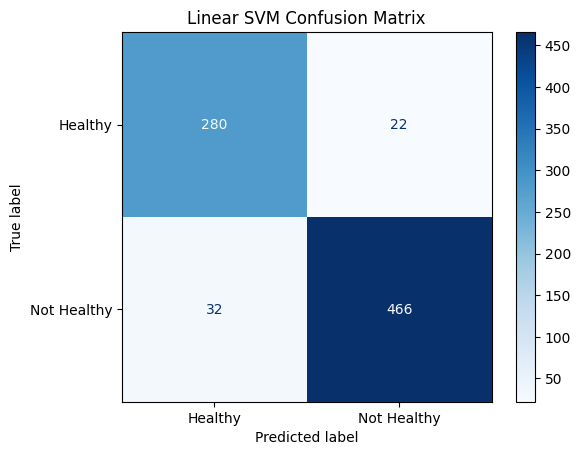

 Test Performance (with 95% CI)
Accuracy: 0.9462 (95% CI: [0.9300, 0.9613])
F1 Score: 0.9566 (95% CI: [0.9427, 0.9692])


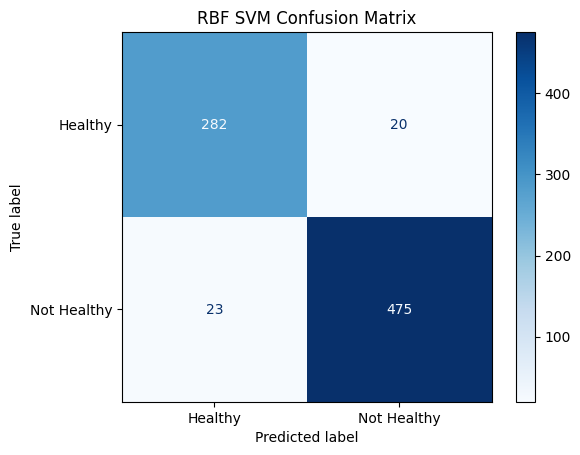

 Test Performance (with 95% CI)
Accuracy: 0.9297 (95% CI: [0.9125, 0.9463])
F1 Score: 0.9426 (95% CI: [0.9277, 0.9568])


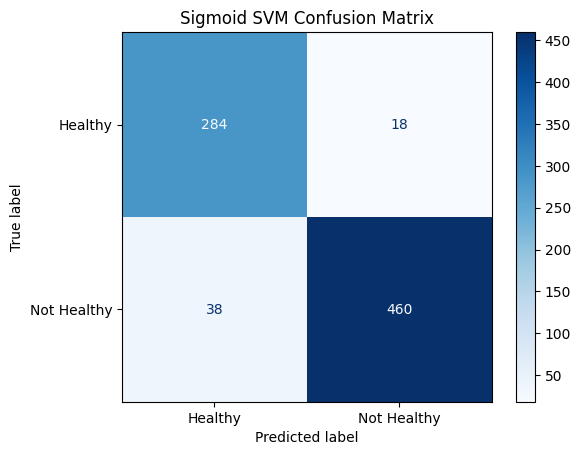

In [14]:
# SVM Test set Evaluation (seed=42 split)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 6000-Level Bootstrap based confidence interval (new addition)
# https://acclab.github.io/bootstrap-confidence-intervals.html
def bootstrap_metric(y_true, y_pred, metric_fn, n_bootstrap=1000):
    n = len(y_true)
    scores = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for _ in range(n_bootstrap):
        indices = np.random.choice(n, n, replace=True)
        score = metric_fn(y_true[indices], y_pred[indices])
        scores.append(score)

    lower = np.percentile(scores, 2.5)
    upper = np.percentile(scores, 97.5)

    return np.mean(scores), lower, upper

models = {
    "Linear SVM": linear_svm_search.best_estimator_,
    "RBF SVM": rbf_svm_search.best_estimator_,
    "Sigmoid SVM": sigmoid_svm_search.best_estimator_
}

svm_results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)

    # Bootstrap confidence intervals
    acc_mean, acc_low, acc_high = bootstrap_metric(
        y_test, y_pred, accuracy_score
    )

    f1_mean, f1_low, f1_high = bootstrap_metric(
        y_test, y_pred,
        lambda y_t, y_p: f1_score(y_t, y_p)
    )

    print(" Test Performance (with 95% CI)")
    print(f"Accuracy: {acc_mean:.4f} (95% CI: [{acc_low:.4f}, {acc_high:.4f}])")
    print(f"F1 Score: {f1_mean:.4f} (95% CI: [{f1_low:.4f}, {f1_high:.4f}])")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Healthy", "Not Healthy"]
    )
    disp.plot(cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()


# Decision thresholding

In [ ]:
# Probability Calibration (Platt Scaling)

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

# Choose best SVM
base_svm = rbf_svm_search.best_estimator_
# Validation split from training data
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42,
    stratify=y_train
)

# Calibrate using sigmoid (Platt scaling)
calibrated_svm = CalibratedClassifierCV(
    estimator=base_svm,
    method="sigmoid",
    cv="prefit"
)

calibrated_svm.fit(X_train_sub, y_train_sub)

# Threshold Selection via Cost Minimization
import numpy as np
from sklearn.metrics import confusion_matrix

val_probs = calibrated_svm.predict_proba(X_val)[:, 1]

# Cost matrix
# Rows = true class, Cols = predicted class
# [[TN, FP],
#  [FN, TP]]
COST_FP = 1
COST_FN = 5

def expected_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return fp * COST_FP + fn * COST_FN

thresholds = np.linspace(0.1, 0.9, 81)
costs = []

for t in thresholds:
    preds = (val_probs >= t)
    costs.append(expected_cost(y_val, preds))

best_threshold = thresholds[np.argmin(costs)]

print(f"Chosen threshold minimizing expected cost: {best_threshold:.2f}")


# Test Set Evaluation: Default vs Chosen Threshold
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_probs = calibrated_svm.predict_proba(X_test)[:, 1]

# Default threshold (0.5)
y_pred_default = (test_probs >= 0.5)

acc_default, acc_low_d, acc_high_d = bootstrap_metric(
    y_test, y_pred_default, accuracy_score
)
f1_default, f1_low_d, f1_high_d = bootstrap_metric(
    y_test, y_pred_default, f1_score
)

print("=== Default Threshold (0.5) ===")
print(f"Accuracy: {acc_default:.4f} (95% CI: [{acc_low_d:.4f}, {acc_high_d:.4f}])")
print(f"F1 Score: {f1_default:.4f} (95% CI: [{f1_low_d:.4f}, {f1_high_d:.4f}])")

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_default,
    display_labels=["Healthy", "Not Healthy"],
    cmap="Blues"
)
plt.title("Confusion Matrix @ Threshold = 0.5")
plt.show()

# Chosen threshold
y_pred_opt = (test_probs >= best_threshold)

acc_opt, acc_low_o, acc_high_o = bootstrap_metric(
    y_test, y_pred_opt, accuracy_score
)
f1_opt, f1_low_o, f1_high_o = bootstrap_metric(
    y_test, y_pred_opt, f1_score
)

print(f"\n=== Chosen Threshold ({best_threshold:.2f}) ===")
print(f"Accuracy: {acc_opt:.4f} (95% CI: [{acc_low_o:.4f}, {acc_high_o:.4f}])")
print(f"F1 Score: {f1_opt:.4f} (95% CI: [{f1_low_o:.4f}, {f1_high_o:.4f}])")

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_opt,
    display_labels=["Healthy", "Not Healthy"],
    cmap="Blues"
)
plt.title(f"Confusion Matrix @ Threshold = {best_threshold:.2f}")
plt.show()


At the default threshold of 0.5, the calibrated SVM achieves strong overall performance (Accuracy = 0.9475, F1 = 0.9578), with balanced errors: 21 false positives and 21 false negatives. This threshold provides a good tradeoff when accuracy is the primary objective, but it still misses a non-trivial number of unhealthy individuals.

When the threshold is lowered to 0.15, chosen to minimize expected cost under a higher penalty for false negatives, the model becomes more conservative in predicting “Healthy.” False negatives drop substantially from 21 to 9, improving the model’s ability to detect unhealthy cases, while false positives increase from 21 to 40. As expected, this shift slightly reduces overall accuracy (0.9387) and F1 score (0.9523).

This tradeoff is appropriate for a health-related screening context, where failing to identify an unhealthy individual is more costly than incorrectly flagging a healthy one. The chosen threshold prioritizes recall for the positive (Not Healthy) class while maintaining strong overall performance, aligning the model’s behavior with domain-specific risk considerations.

## 6000-level Confidence Interval Bootstrap Analysis

The bootstrap confidence intervals provide an estimate of uncertainty around each metric by repeatedly resampling the test set. Under the default threshold (0.5), the model achieves an accuracy of 0.9476 with a 95% confidence interval of [0.9313, 0.9625], and an F1 score of 0.9577 with a 95% CI of [0.9453, 0.9698]. These relatively narrow intervals indicate stable performance and low variability across bootstrap samples.

When using the cost-optimized threshold (0.15), accuracy decreases slightly to 0.9386 (95% CI: [0.9225, 0.9538]) and F1 to 0.9520 (95% CI: [0.9380, 0.9642]). The overlapping confidence intervals between the two thresholds suggest that the performance differences are modest and may not be statistically substantial. However, the lower threshold shifts the balance toward reducing false negatives (as intended by the higher FN cost), even at a small trade-off in overall accuracy.